In [29]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import lib

<h1>Spike-Response-Model (SRM)</h1>
<img src="img/Screenshot 2023-01-28 alle 17.42.45.png">
￼<ul>
<li>Input: corrente I(t)</li>
<li>Filtro lineare chiamato kernel k(s), passa basso, membrana cellulare: produce un output h(t) che è la componente della tensione di membrana a regime subthreshold, che viene direttamente determinata dalla costante di tempo τ=RcanaleCmembrana</li>
<li>Sul nodo di retroazione possiamo (dobbiamo) aggiungere il potenziale di riposo: la h(t) così diventa il potenziale di membrana che avremmo se non esistesse il meccanismo di generazione di AP, ovvero il potenziale di membrana sub threshold</li>
<li>f(u-θ) fa riferimento alla funzione di soft threshold, che esprime la probabilità di emissione dell’AP in funzione della distanza dalla soglia (si può benissimo rendere dipendente anche dalla derivata di  u(t), per avvantaggiare (o svantaggiare) gli incrementi improvvisi. * Il dado indica semplicemente che la nonlinearità ha una natura stocastica.</li>
<li>Il treno di AP viene riportato in retroazione su h(t), ottenendo u(t), che è un valore in V che tiene conto di:
<ol>
    <li>Forma d’onda del potenziale </li>
    <li>Spike after-potential, cioè la fase di depressione (iperpolarizzazione) successiva all’AP, in cui u(t)-Urest < 0. La convoluzione di un altro kernel, chiamato η(t) con il treno di spike S(t) dà luogo al potenziale di membrana effettivo u(t)</</li></li>
<li>(Opzionale) Inoltre viene retroazionato sulla f(u-θ), modificando θ per tenere conto dell’adattività, caratterizzato da θ1 che moltiplica S(t). Se vogliamo un tempo refrattario assoluto dovremo avere un picco di θ1 nei primi millisecondi, e poi rilassarlo in quelli successivi (+100ms)</li>
</ul>

Possiamo semplificare il modello:
<ul>
<li>È possibile fare una piccola modifica non condizionante nel caso in cui non ci interessa tenere traccia della tensione di membrana ASSOLUTA (ma al massimo di quella relativa agli AP), accorpando il threshold dinamico con lo spike after potential effettuando un cambio di variabile da η(t-tf) a η(t-tf)-θ1(t-tf). Questo rimuove la dipendenza temporale di θ accorpandola in η(t) (che adesso è lo spike after potential effettivo, non più sperimentale)</li>
<li>Se non vogliamo nemmeno tenere in considerazione la forma d’onda del potenziale d’azione, η può degenerare in una semplice funzione che resetta il potenziale di membrana a Urest a ogni AP, proprio come nel modello integrate-and-fire. In quel caso, è un esponenziale negativo che resetta a Urest e decade in τm.</li>


   * viene chiamato anche noisy threshold, o modello con escape noise. Un SRM che include un escape noise è un esempio di Generalized Linear Model (GLM)


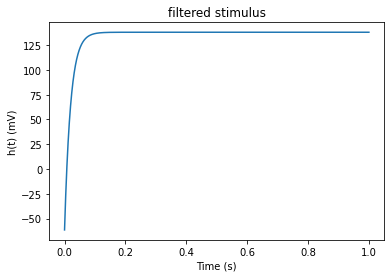

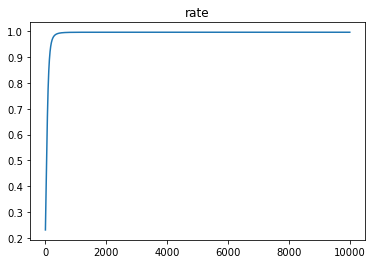

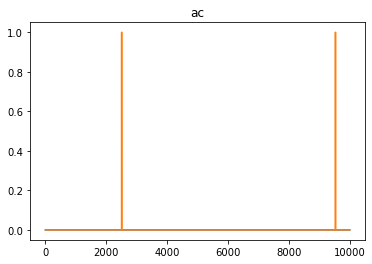

n ap = 2


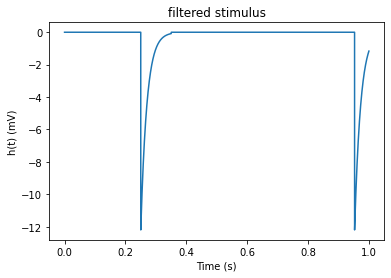

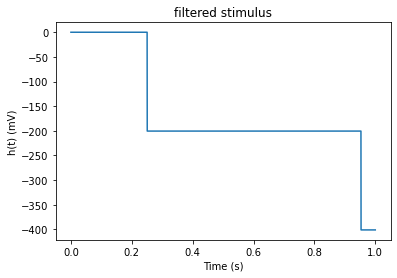

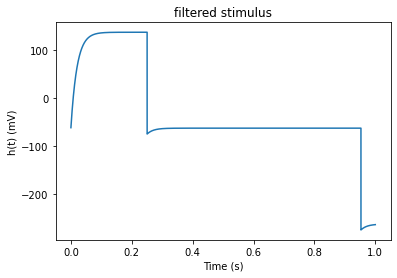

In [63]:
importlib.reload(lib)

time_step = 0.1e-3
simulation_time = 1
membrane_tau = 20e-3
N = (int)(simulation_time//time_step)
Urest = -62.5e-3
Threshold_rest = -48.9e-3
hyperpolarization_voltage = -74.7e-3
# Supponiamo di usare una corrente continua di 1nA per la stimulazione intanto
current = 1e-9*np.ones(N)

C = 1e-6 #F/cm^2
linear_filter = np.zeros(N)
for i in range(N):
    linear_filter[i] = 1/C*np.exp(-time_step*i/membrane_tau) 

h = np.convolve(current, linear_filter)[:N]
u = h + Urest
plt.plot(np.arange(0, simulation_time-time_step, time_step), (u*1000))
#plt.axis([0, 600, -0.5, 0.5])
plt.title("filtered stimulus")
plt.xlabel("Time (s)")
plt.ylabel("h(t) (mV)")
plt.show()


rate = np.zeros(N)
rate = lib.sigmoidal_nonlinearity(h)
plt.plot(rate)
#plt.axis([0, 600, 0, 1.1])
plt.title("rate")
plt.show()

spike_probability=np.zeros(N)
#spike_probability = lib.poisson(rate, time_step)
spike_probability = time_step*rate
plt.plot(spike_probability)
plt.title("spike probability")
#plt.show()

ap = np.zeros(N)
for i in range(N):
    rand = np.random.random()
    ap[i] = 1 if rand < spike_probability[i] else 0
plt.plot(ap)
#plt.axis([0, 600, 0, 1.1])
plt.title("ac")
plt.show()
print("n ap = %d"%np.sum(ap))

eta = np.zeros(int(0.1/time_step))
for i in range(eta.size):
    eta[i] = np.exp(-i*time_step/membrane_tau)

u2 = np.convolve(ap*(-Urest+hyperpolarization_voltage), eta)[:N]
plt.plot(np.arange(0, simulation_time-time_step, time_step), (u2*1000))
#plt.axis([0, 600])
plt.title("filtered stimulus")
plt.xlabel("Time (s)")
plt.ylabel("h(t) (mV)")
plt.show()

u3 = np.convolve(ap*(Urest-u), np.ones(N))[:N]
plt.plot(np.arange(0, simulation_time-time_step, time_step), (u3*1000))
#plt.axis([0, 600])
plt.title("filtered stimulus")
plt.xlabel("Time (s)")
plt.ylabel("h(t) (mV)")
plt.show()

plt.plot(np.arange(0, simulation_time-time_step, time_step), ((u+u2+u3)*1000))
#plt.axis([0, 600])
plt.title("filtered stimulus")
plt.xlabel("Time (s)")
plt.ylabel("h(t) (mV)")
plt.show()